In [10]:
import torch
from rdkit import Chem
import numpy as np
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import svgutils.transform as sg
from sklearn.preprocessing import MinMaxScaler
from rdkit.Chem.rdchem import RWMol
from rdkit.Chem import Atom, AtomValenceException
from rdkit import RDLogger
import torch.nn.functional as F

from ipywidgets import interact

RDLogger.DisableLog('rdApp.*')

class GNNInterpreter:
    def __init__(self, model, featurizer, log=False):
        self.model = model
        self.featurizer = featurizer
        self.log = log
        self.organic_atoms = [Atom(symbol) for symbol in  ['Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S']]
    
    def _log(self, msg):
        if self.log:
            print(msg)

    def _get_original_pred(self):
        nodes, edges = self.featurizer.process_mol(self.mol)
        x = torch.FloatTensor(nodes)
        edge_index = torch.LongTensor(edges)
        batch = torch.zeros(x.shape[0], dtype=torch.int64)

        return self.model(x, edge_index, batch).item()

    # throws
    def _getReplacedMol(self, atom, replacement, replace_atom_alg):
        molRW = RWMol(self.mol)

        if replace_atom_alg == 'number':
            molRW.GetAtoms()[atom.GetIdx()].SetAtomicNum(replacement.GetAtomicNum())
        elif replace_atom_alg == 'atom':
            molRW.ReplaceAtom(atom.GetIdx(), replacement, preserveProps=True)

        molRW.UpdatePropertyCache()

        return molRW
    

    def _get_replaced_data_prediction(self, atom, replacement, replace_atom_alg):
        if replacement:
            try:
                replaced_mol = self._getReplacedMol(atom, replacement, replace_atom_alg)
            except AtomValenceException:
                self._log(f"Replacing {atom.GetSymbol()} with {replacement.GetSymbol()} failed.")
                return np.nan

            nodes, edges = self.featurizer.process_mol(replaced_mol)

            self._log(f'before replacement {atom.GetSymbol()} at {atom.GetIdx()}: Chem.MolToSmiles(self.mol)')
            self._log(f'after  replacement {atom.GetSymbol()} at {atom.GetIdx()}: Chem.MolToSmiles(replaced_mol)')
        else:
            nodes, edges = self.featurizer.process_mol(self.mol)
            nodes[atom.GetIdx()][:11] = torch.zeros((11,))

        x = torch.FloatTensor(nodes)
        edge_index = torch.LongTensor(edges)
        batch = torch.zeros(x.shape[0], dtype=torch.int64)

        return self.model(x, edge_index, batch).item()

    def _calculate_atom_weight(self, atom, replace_atom_with, replace_atom_alg, calculate_atom_weight_alg):
        model_preds = []

        # get model preds
        if replace_atom_with == 'all':
            for organic_atom in self.organic_atoms:
                model_preds.append(self._get_replaced_data_prediction(atom, organic_atom, replace_atom_alg))
        elif replace_atom_with == 'zero':
            model_preds.append(self._get_replaced_data_prediction(atom, None, replace_atom_alg))
        else:
            organic_atom = Atom(replace_atom_with)
            model_preds.append(self._get_replaced_data_prediction(atom, organic_atom, replace_atom_alg))

        model_preds = np.array(model_preds)
        original_pred = self._get_original_pred()

        #calculate weight
        if calculate_atom_weight_alg == 'absolute':
            prepared_diff = np.abs(original_pred - model_preds)
        elif calculate_atom_weight_alg == 'signed':
            prepared_diff = model_preds - original_pred

        not_nans = prepared_diff[~np.isnan(prepared_diff)]
        atom_weight = not_nans.mean() if len(not_nans) != 0 else np.nan

        return atom_weight
    
    def _calc_atoms_weight(self, replace_atoms_with, replace_atoms_alg, calculate_atoms_weight_alg):
        atom_weights = []
        for atom in self.mol.GetAtoms():
            atom_weights.append(self._calculate_atom_weight(atom, replace_atoms_with, replace_atoms_alg, calculate_atoms_weight_alg))

        return np.array(atom_weights, dtype=np.float)

    def _get_atom_colors(self, atom_weights):
        positive_idx = atom_weights > 0
        
        if positive_idx.any():
            atom_weights[positive_idx] = MinMaxScaler(feature_range=(0,1)).fit_transform(atom_weights[positive_idx].reshape(-1, 1)).reshape(-1, )
        if ~positive_idx.any():
            atom_weights[~positive_idx] = MinMaxScaler(feature_range=(-1,0)).fit_transform(atom_weights[~positive_idx].reshape(-1, 1)).reshape(-1, )

        atom_weights /= 2.0

        norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
        cmap= cm.get_cmap('RdYlGn')
        plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
        nan_color = (0.701, 0.631, 0.988)

        atom_colors = {
            i: plt_colors.to_rgba(atom_weights[i]) if ~np.isnan(atom_weights[i]) else nan_color for i in range(len(atom_weights))
        }

        return atom_colors

    def _generate_importance_map(self, atom_weights, positive_only):
        atom_colors = self._get_atom_colors(atom_weights)
        highlight_kwargs = {
            'highlightAtoms': list(range(len(atom_weights))),
            'highlightBonds': [],
            'highlightAtomColors': atom_colors
        }

        # for idx, atom in enumerate(self.mol.GetAtoms()):
        #     if ~np.isnan(atom_weights[idx]):
        #         atom.SetProp('atomNote', f'{atom_weights[idx]:2.3}')
        #     else:
        #         atom.SetProp('atomNote', 'N/D')

        #draw molecule
        d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
        rdMolDraw2D.PrepareAndDrawMolecule(d, self.mol, **highlight_kwargs)
        d.FinishDrawing()
        svg = d.GetDrawingText()
        svg = svg.replace('svg:', '')

        #generate importance map reference
        figure = plt.figure(figsize=(4, 2), dpi=80)
        if positive_only:
            gradient = np.linspace(0.5, 1, 256).reshape((1, 256))
            plt.xticks([0, 255], ['unimportant', 'important'])
        else:
            gradient = np.linspace(0, 1, 256).reshape((1, 256))
            plt.xticks([0, 255], ['negative', 'positive'])
        plt.imshow(gradient, aspect=10, cmap='RdYlGn', vmin=0.0, vmax=1.0)
        plt.yticks([])
        plt.close()

        # combine final svg
        fig = sg.fromstring(svg)
        im2 = sg.from_mpl(figure).getroot()
        im2.moveto(-5, -50)

        fig.append(im2)

        return SVG(fig.to_str()), fig

    def grad_cam(self):
        final_conv_acts, final_conv_grads = model.final_conv_acts, model.final_conv_grads
        node_heat_map = []
        alphas = torch.mean(final_conv_grads, axis=0)
        for n in range(final_conv_acts.shape[0]): # nth node
            node_heat = F.relu(alphas @ final_conv_acts[n]).item()
            node_heat_map.append(node_heat)
        return np.array(node_heat_map)

    def get_importance_map_svg(self, mol, method='substitution', replace_atoms_with='all', replace_atom_alg='number', calculate_atom_weight_alg='signed'):
        if type(mol) is Chem.Mol:
            self.mol = Chem.Mol(mol)
        else:
            self.mol = Chem.MolFromSmiles(mol)
        if method == 'substitution':
            atom_weights = self._calc_atoms_weight(replace_atoms_with, replace_atom_alg, calculate_atom_weight_alg)
        elif method == 'gradcam':
            atom_weights = self.grad_cam()
        
        importance_map = self._generate_importance_map(atom_weights, positive_only=calculate_atom_weight_alg == 'absolute' or method == 'gradcam')

        return importance_map

        

In [3]:
project_dir = '.'
model = torch.load(project_dir + '/GCNRegressor.pth')

df, fold_indices = load_esol(split_path= project_dir + '/data/esol/split.npz')
featurizer = GraphFeaturizer(y_column='measured log solubility in mols per litre')
mol = Chem.MolFromSmiles(df.iloc[fold_indices[0][60]].smiles)

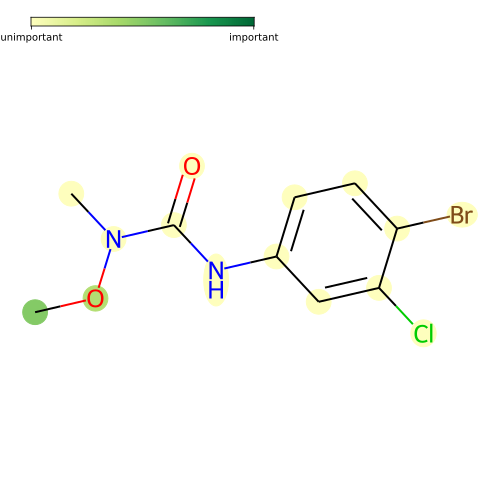

In [11]:
interpreter = GNNInterpreter(model, featurizer)
svg, fig = interpreter.get_importance_map_svg(mol,replace_atoms_with='zero', method='gradcam')
fig.save('fig.svg')
svg

In [8]:
from ipywidgets import interact

@interact(method=['substitution', 'gradcam'], replace_atoms_with=['all', 'zero', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S'], replace_atom_alg=['number', 'atom'], calculate_atom_weight_alg=['signed', 'absolute'])
def interactive(mol='CON(C)C(=O)Nc1ccc(Br)c(Cl)c1', method='substitution', replace_atoms_with='zero', replace_atom_alg='number', calculate_atom_weight_alg='signed'):
    interpreter = GNNInterpreter(model, featurizer)
    return interpreter.get_importance_map_svg(mol, method, replace_atoms_with, replace_atom_alg, calculate_atom_weight_alg)[0]

interactive(children=(Text(value='CON(C)C(=O)Nc1ccc(Br)c(Cl)c1', description='mol'), Dropdown(description='met…

In [2]:
from mldd.data import Featurizer
import numpy as np

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


class GraphFeaturizer(Featurizer):
    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row.smiles
            mol = Chem.MolFromSmiles(smiles)
            graph = self.process_mol(mol)
            graphs.append(graph)
            labels.append(y)
        labels = np.array(labels)
        return graphs, labels

    def process_mol(self, mol):
        edges = []
        for bond in mol.GetBonds():
            edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
            edges.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
        edges = np.array(edges)
            
        nodes = []
        for atom in mol.GetAtoms():
            results = one_of_k_encoding_unk(
                atom.GetSymbol(),
                [
                    'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Unknown'
                ]
            ) + one_of_k_encoding(
                atom.GetDegree(),
                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
            ) + one_of_k_encoding_unk(
                atom.GetImplicitValence(),
                [0, 1, 2, 3, 4, 5, 6]
            ) + [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + one_of_k_encoding_unk(
                atom.GetHybridization(),
                [
                    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                    Chem.rdchem.HybridizationType.SP3D2
                ]
            ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                atom.GetTotalNumHs(),
                [0, 1, 2, 3, 4]
            )
            nodes.append(results)
        nodes = np.array(nodes)

        return (nodes, edges.T)

from torch_geometric.data import InMemoryDataset, Data  # TODO

class GraphDataset(InMemoryDataset):  # TODO
    def __init__(self, X, y, root, transform=None, pre_transform=None):
        self.dataset = (X, y)
        super().__init__(root, transform, pre_transform)
        
        self.download()
        self.process()

        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        data = []
        # TODO (data should be a list of graphs)

        for (nodes, edges), target in zip(*self.dataset):
            nodes = torch.tensor(nodes, dtype=torch.float)
            edges = torch.tensor(edges, dtype=torch.long)
            target = torch.tensor(target, dtype=torch.float)
            
            graph = Data(x=nodes, edge_index=edges, y=target)
            graph.num_nodes = nodes.shape[0]
            data.append(graph)

        torch.save(data, self.raw_paths[0])
        

    def process(self):
        # Read data into huge `Data` list.
        data_list = torch.load(self.raw_paths[0])
        
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, Sequential as GraphSequential

from torch.nn import ReLU
from torch_geometric.nn import GCNConv, Linear, global_mean_pool

class GCNRegressor(torch.nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()

        self.input = None
        self.final_conv_acts = None
        self.final_conv_grads = None

        self.conv1 = GCNConv(input, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.conv3 = GCNConv(hidden, hidden)
        self.conv4 = GCNConv(hidden, output)
        self.linear = Linear(output, 1)
        self.relu = ReLU(inplace=True)
    
    def activations_hook(self, grad):
        self.final_conv_grads = grad

    def forward(self, x, edge_index, batch):
        x.requires_grad = True
        self.input = x

        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.conv3(x, edge_index)
        x = self.relu(x)
        with torch.enable_grad():
            self.final_conv_acts = self.conv4(x, edge_index)
        self.final_conv_acts.register_hook(self.activations_hook)

        x = global_mean_pool(self.final_conv_acts, batch=batch)
        x = self.linear(x)

        return x

from mldd.data import load_esol